In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorrt as trt
from cuda import cudart  # Requires: pip3 install nvidia-cuda-python

In [ ]:
image_path = "/home/group5/AI_Cannon/milestone2/samples/IMG_3032.JPG"
engine_path = "/home/group5/AI_Cannon/milestone2/model/yolov5s_custom.engine"

In [ ]:
class YOLOv5TRTNoPyCUDA:
    def __init__(self, engine_path, input_hw=(640, 640)):
        self.logger = trt.Logger(trt.Logger.INFO)
        self.runtime = trt.Runtime(self.logger)
        self.input_hw = input_hw

        with open(engine_path, "rb") as f:
            engine_data = f.read()
        self.engine = self.runtime.deserialize_cuda_engine(engine_data)
        if not self.engine:
            raise RuntimeError("Failed to load TensorRT engine.")

        self.context = self.engine.create_execution_context()
        self.input_idx = self.engine.get_binding_index("input")
        self.output_idx = self.engine.get_binding_index("output")

        self.input_shape = list(self.engine.get_binding_shape(self.input_idx))
        self.output_shape = list(self.engine.get_binding_shape(self.output_idx))

        self.input_dtype = trt.nptype(self.engine.get_binding_dtype(self.input_idx))
        self.output_dtype = trt.nptype(self.engine.get_binding_dtype(self.output_idx))

        self.host_input = np.zeros(self.input_shape, dtype=self.input_dtype)
        self.host_output = np.zeros(self.output_shape, dtype=self.output_dtype)

        self.d_input = None
        self.d_output = None

        self.context.set_binding_shape(self.input_idx, self.input_shape)

    def infer(self, frame):
        H, W = self.input_hw
        img = cv2.resize(frame, (W, H))
        img = img.astype(self.input_dtype) / 255.0
        img = np.transpose(img, (2, 0, 1))
        img = np.expand_dims(img, axis=0)
        self.host_input[...] = img

        if self.d_input is None:
            n_input_bytes = self.host_input.nbytes
            n_output_bytes = self.host_output.nbytes
            self.d_input = cudart.cudaMalloc(n_input_bytes)[1]
            self.d_output = cudart.cudaMalloc(n_output_bytes)[1]

        # Host->Device
        cudart.cudaMemcpy(self.d_input, self.host_input.ctypes.data, self.host_input.nbytes, cudart.cudaMemcpyKind.cudaMemcpyHostToDevice)

        bindings = [0] * self.engine.num_bindings
        bindings[self.input_idx] = self.d_input
        bindings[self.output_idx] = self.d_output

        self.context.execute_v2(bindings)

        # Device->Host
        cudart.cudaMemcpy(self.host_output.ctypes.data, self.d_output, self.host_output.nbytes, cudart.cudaMemcpyKind.cudaMemcpyDeviceToHost)

        return self.host_output

    def postprocess(self, output, original_hw):
        original_h, original_w = original_hw
        model_h, model_w = self.input_hw
        scale_h = original_h / model_h
        scale_w = original_w / model_w

        result = []
        for det in output[0]:
            conf = det[4]
            if conf > 0.5:
                x1, y1, x2, y2 = det[0:4]
                x1 = int(x1 * scale_w)
                x2 = int(x2 * scale_w)
                y1 = int(y1 * scale_h)
                y2 = int(y2 * scale_h)
                result.append((x1, y1, x2, y2, conf))
        return result

[01/09/2025-15:39:56] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[01/09/2025-15:39:56] [TRT] [I] Loaded engine size: 16 MiB
[01/09/2025-15:39:56] [TRT] [W] Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
[01/09/2025-15:39:56] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +14, now: CPU 0, GPU 43 (MiB)
[01/09/2025-15:39:56] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +16, now: CPU 0, GPU 59 (MiB)


/tmp/ipykernel_5718/237402477.py:20: DeprecationWarning: Use get_tensor_name instead.
  self.input_idx = self.engine.get_binding_index("input")   # 실제 텐서 이름 확인 필요
/tmp/ipykernel_5718/237402477.py:21: DeprecationWarning: Use get_tensor_name instead.
  self.output_idx = self.engine.get_binding_index("output") # 실제 텐서 이름 확인 필요
/tmp/ipykernel_5718/237402477.py:23: DeprecationWarning: Use get_tensor_shape instead.
  self.input_shape = list(self.engine.get_binding_shape(self.input_idx))
/tmp/ipykernel_5718/237402477.py:24: DeprecationWarning: Use get_tensor_shape instead.
  self.output_shape = list(self.engine.get_binding_shape(self.output_idx))
/tmp/ipykernel_5718/237402477.py:26: DeprecationWarning: Use get_tensor_dtype instead.
  self.input_dtype = trt.nptype(self.engine.get_binding_dtype(self.input_idx))
/tmp/ipykernel_5718/237402477.py:27: DeprecationWarning: Use get_tensor_dtype instead.
  self.output_dtype = trt.nptype(self.engine.get_binding_dtype(self.output_idx))
/tmp/ipykernel_571

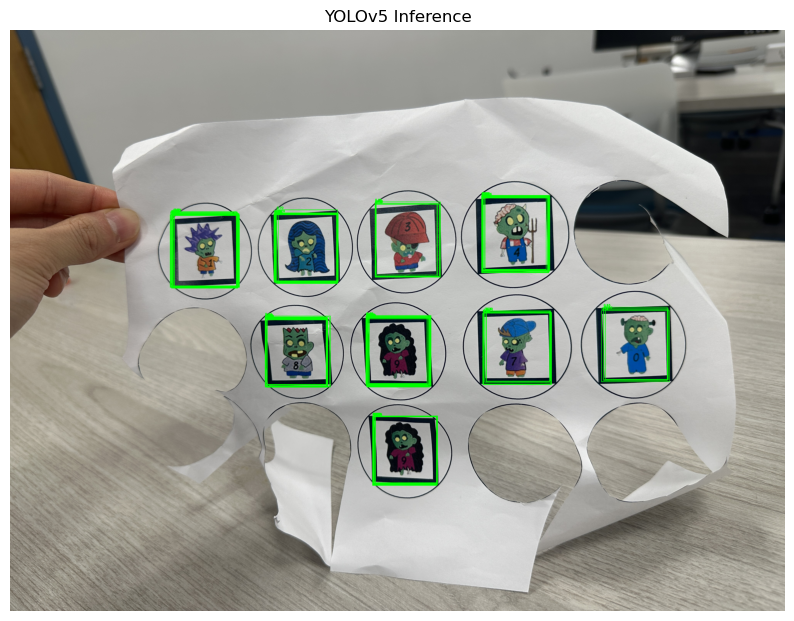

In [7]:
yolo = YOLOv5TRTNoPyCUDA(engine_path, input_hw=(640, 640))

img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

original_hw = img.shape[:2]

raw_output = yolo.infer(img)
detections = yolo.postprocess(raw_output, original_hw)

for (x1, y1, x2, y2, conf) in detections:
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{conf:.2f}", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("YOLOv5 Inference")
plt.show()
